In [1]:
import cv2
import numpy as np
import torch
from model_factory import prepare_model
from torch.utils.data import DataLoader
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import os
os.environ["WANDB_MODE"]='offline'
import wandb

from architectures.SiameseSimple import SiameseSimple
from dataset_io import SimilarityDataset

from metrics import tpr_fpr, plot_ROC

In [31]:
try:
    wandb.finish()
except:
    "No wandb instance to close, continue to start new"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device.format(device)} device')

wandb.init(project="texsim2018", entity='shamann', group='FirstTraining', config={
    "image_size":(1,150,150),
    "batch_size": 32,
    "architecture": "SiameseNetworkLeaky_tiny",
    "dataset": "SimTex2018",
    "max_images":8,
    "max_samples":16
})
config = wandb.config

wandb: You can sync this run to the cloud by running:
wandb: wandb sync C:\Repositories\PythonRepos\TexSim2018\wandb\offline-run-20210512_230353-1h3jkpg1


Using cuda device


wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


In [34]:
training_desc = 'Train_on100x16imagesLeaky_e50_b32_lr0.002/'
models_root = 'models/'+training_desc
model, model_name, _ = prepare_model(SiameseSimple, models_root, device)

Loaded model: models/Train_on100x16imagesLeaky_e50_b32_lr0.002/model_SiameseNetworkLeaky_tiny-e_027-b_000.h5


In [14]:
test_data = SimilarityDataset('data/test', max_samples=config.max_samples, max_images=config.max_images)

Data: 100%|██████████| 52/52 [00:01<00:00, 35.15it/s]


In [16]:
test_data.reset()


In [17]:
samples_predicted = []
for i in range(config.max_images):
    all_samples = test_data.get_samples(i)
    print(test_data.image_names[i])
    embeddings = model.forward_branch(all_samples.to(device))
    labels = np.zeros((len(embeddings),1),dtype=np.int32) + i
    embeddings = torch.squeeze(embeddings)
    samples_predicted.append(np.concatenate((labels,embeddings.to('cpu').detach().numpy()),axis=1))

data/test\pexels-photo-113338.jpg
data/test\pexels-photo-122458.jpg
data/test\pexels-photo-127567.jpg
data/test\pexels-photo-129722.jpg
data/test\pexels-photo-129723.jpg
data/test\pexels-photo-129731.jpg
data/test\pexels-photo-159062.jpg
data/test\pexels-photo-161690.jpg


In [61]:
len(samples_predicted)

8

In [18]:
samples = np.concatenate(samples_predicted, axis=0)

In [19]:
samples[:10,:]

array([[ 0.        , -0.4806869 , -0.75317574,  0.75575924],
       [ 0.        , -0.27768335, -1.71011651,  0.05538362],
       [ 0.        , -0.30955839, -0.24584015, -1.01961696],
       [ 0.        , -0.11577733,  0.65736216, -0.0425691 ],
       [ 0.        ,  0.30107415,  1.12218881, -0.07268535],
       [ 0.        , -1.08256161,  0.99108624, -0.69255036],
       [ 0.        ,  0.24984951,  0.58601815, -0.471452  ],
       [ 0.        , -0.62093329, -0.11119739,  0.11521887],
       [ 0.        ,  0.08623673,  0.44652587, -0.03651581],
       [ 0.        ,  0.29889816, -0.23550539,  0.81086731]])

In [20]:
fig = px.scatter_3d(samples[:,1:4], x=0, y=1, z=2, color=samples[:,0],
                    title='Embeddings', labels={'0':'x','1':'y','2':'z'}, opacity=0.5)
fig.show()

In [21]:
test_dataloader = DataLoader(test_data, config.batch_size, shuffle=True, num_workers=0)

Evaluate Metrics and Save predicted samples

In [49]:
save_to = 'data/predictions/'+training_desc
if not os.path.exists(save_to):
    os.makedirs(save_to+'/tp')
    os.makedirs(save_to+'/tn')
    os.makedirs(save_to+'/fp')
    os.makedirs(save_to+'/fn')
save_name = 'E_{:02d}-b_{:03d}-d_{:.4f}.jpg'
split = np.ones((1,config.image_size[1],3))

In [50]:
save_name.format(3,20,0.34423424)

'E_03-b_020-d_0.3442.jpg'

In [53]:
# accuracy_mean = 0
# precision_mean = 0
# recall_mean = 0
batches = 0

distances = []
y_true = []
tp = 0
tn = 0
fp = 0
fn = 0
for epoch in range(10):
    test_data.reset()
    for batch, (x1, x2, y) in tqdm(enumerate(test_dataloader), total=int(np.ceil(len(test_data)/config.batch_size))):
        if len(x1) != config.batch_size:
            print(f" ... Skipping small batch <{len(x1)}>")
            continue

        out1, out2 = model.forward(x1.to(device), x2.to(device))
        distance, _ = model.distance_euclid(out1, out2)
        distances = np.concatenate((distances,distance.detach().cpu().numpy()),axis=0)
        thresh = 1.19
        for dist,s1,s2,t in zip(distances,x1,x2,y):
            if dist < thresh and t:
                cv2.imwrite(os.path.join(save_to,'tp',save_name.format(epoch,batch,dist)), np.concatenate((s1.numpy(),split,s2.numpy()), axis=2).transpose([1,2,0])*255)
                tp+=1
            if dist < thresh and not t:
                cv2.imwrite(os.path.join(save_to,'fp',save_name.format(epoch,batch,dist)), np.concatenate((s1.numpy(),split,s2.numpy()), axis=2).transpose([1,2,0])*255)
                fp+=1
            if dist >= thresh and not t:
                cv2.imwrite(os.path.join(save_to,'tn',save_name.format(epoch,batch,dist)), np.concatenate((s1.numpy(),split,s2.numpy()), axis=2).transpose([1,2,0])*255)
                tn+=1
            if dist >= thresh and t:
                cv2.imwrite(os.path.join(save_to,'fn',save_name.format(epoch,batch,dist)), np.concatenate((s1.numpy(),split,s2.numpy()), axis=2).transpose([1,2,0])*255)
                fn+=1
        y_true = np.concatenate((y_true,y.cpu().numpy()),axis=0)
        # similarity = (distance < thresh).float()
        # correct = (similarity==y.to(device)).float().sum()
        # accuracy_mean += correct/x1.shape[0]
        # precision_mean += torch.sum((similarity * y.to(device))) / torch.sum((similarity * y.to(device)) + (similarity * (y.to(device)*-1+1)))
        # recall_mean += torch.sum((similarity * y.to(device))) / torch.sum((similarity * y.to(device)) + ((similarity*-1+1) * y.to(device)))
        batches += 1


# print(f"Test Accuracy: {accuracy_mean/batches}")
# print(f"Test Precision: {precision_mean/batches}")
# print(f"Test Recall: {recall_mean/batches}")
print(f"Test Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")
print(f"Test Precision: {(tp)/(tp+fp)}")
print(f"Test Recall: {(tp)/(tp+fn)}")

    # _, axs = plt.subplots(1, config.batch_size, figsize=[12, 4])
    # for ii, (i1, i2, t, d) in enumerate(zip(x1, x2, y, distance)):
    #     axs[ii].imshow(torch.cat((i1, i2), dim=1).permute(1, 2, 0), cmap='gray')
    #     axs[ii].set_title("D: {:.3f} Y:{:.1f}".format(d.item(), t.item()))
    # plt.show()
    # plt.close()

 75%|███████▌  | 3/4 [00:07<00:02,  2.52s/it]

 ... Skipping small batch <24>

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 ... Skipping small batch <24>


  0%|          | 0/4 [00:00<?, ?it/s]

 ... Skipping small batch <24>


  0%|          | 0/4 [00:00<?, ?it/s]

 ... Skipping small batch <24>


  0%|          | 0/4 [00:00<?, ?it/s]

 ... Skipping small batch <24>


  0%|          | 0/4 [00:00<?, ?it/s]

 ... Skipping small batch <24>


  0%|          | 0/4 [00:00<?, ?it/s]

 ... Skipping small batch <24>


  0%|          | 0/4 [00:00<?, ?it/s]

 ... Skipping small batch <24>


  0%|          | 0/4 [00:00<?, ?it/s]

 ... Skipping small batch <24>


100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

 ... Skipping small batch <24>
Test Accuracy: 0.5020833333333333
Test Precision: 0.45897435897435895
Test Recall: 0.4013452914798206


In [26]:
tprs = []
fprs = []
thresholds = np.array(list(range(480)))/100
for i in range(480):
    tpr, fpr = tpr_fpr(distances,y_true,i/100)
    tprs.append(tpr)
    fprs.append(fpr)

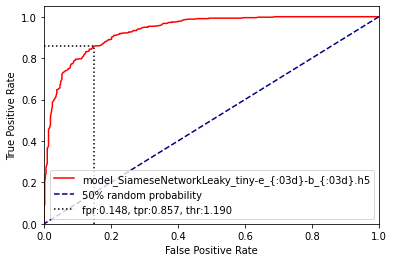

1.19

In [24]:
plot_ROC(tprs,fprs,thresholds,model_name,'red')

In [ ]:
wandb.finish()

Try this shit with whole images

In [ ]:
pather = lambda x: os.path.join('data/test',x)
files = list(map(pather, os.listdir('data/test')))

class data:
    def __init__(self,files):
        self.samples = [np.array(np.transpose(np.expand_dims(cv2.imread(x, cv2.IMREAD_GRAYSCALE) / 255, axis=2),axes=[2,0,1]), dtype=np.float32) for x in files]
    def get_samples(self,item):
        return torch.from_numpy(np.expand_dims(self.samples[item], axis=0))

whole_data = data(files)

In [ ]:
for i,f in enumerate(files):
    print(i,f)

In [47]:
samples_predicted = []
for i in range(len(whole_data.samples)):
    all_samples = whole_data.get_samples(i)
    # print(test_data.image_names[i])
    embeddings = model.forward_branch(all_samples.to(device))
    embeddings = torch.squeeze(embeddings)
    samples_predicted.append(np.concatenate(([i],embeddings.to('cpu').detach().numpy()),axis=0))

In [ ]:
fig = px.scatter_3d(np.array(samples_predicted)[:,1:4], x=0, y=1, z=2, color=np.array(samples_predicted)[:,0],
                    title='Embeddings', labels={'0':'x','1':'y','2':'z'}, opacity=0.5)
fig.show()